<a href="https://colab.research.google.com/github/SeneKim/4th-SKT_Fly_AI/blob/main/Generative%20AI/LangChain/LangChain_07_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

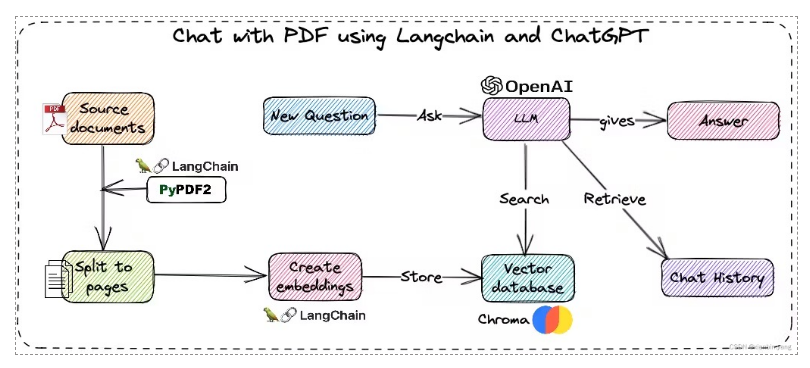

### 검색해서 결과를 가져오기

In [ ]:
!pip install openai langchain tiktoken sentence_transformers chromadb pypdf

In [ ]:
import os

# 환경변수 세팅하기
os.environ['OPENAI_API_KEY'] = 'KEY'
os.environ['AZURE_OPENAI_ENDPOINT'] = 'ENDPOINT'
os.environ['OPENAI_API_TYPE'] = 'azure'
os.environ['OPENAI_API_VERSION'] = '2023-05-15'

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

def tiktoken_len(text):
  tokens = tokenizer.encode(text)
  return len(tokens)

In [ ]:
# PDF파일 로드
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader('/content/[정책브리프 2021-04] 탄소중립 대응을 위한 정부 정책과 동향 (1).pdf')
pages = loader.load_and_split()

In [ ]:
# data split 하는 부분
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50,
    length_function = tiktoken_len
)

docs = text_splitter.split_documents(pages)

In [ ]:
# 모델 다운 - hugging face에서 embedding model 다운로드
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = 'jhgan/ko-sbert-nli'
model_kwargs = {'device' : 'cpu'}
encode_kwargs = {'normalize_embeddings' : True}


hf = HuggingFaceBgeEmbeddings(
    model_name = model_name,
    model_kwargs = model_kwargs,
    encode_kwargs = encode_kwargs
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Vector DB 선언 및 문서에 있는 token 임베딩
from langchain.vectorstores import Chroma

# 임베딩할 문서와 임베딩 문서를 넣어줍니당!
# pdf의 내용이 모두 잘라지고 vector store에 들어감
db = Chroma.from_documents(docs, hf)

In [ ]:
# make answer
# 우리의 목적: 검색 - 대답
from langchain.chains import RetrievalQA
from langchain.chat_models import AzureChatOpenAI

# 언어 모델 만들고 chain으로 묶어주기
openai = AzureChatOpenAI(
    deployment_name = "dev-gpt-35-turbo",
)

# chain definition
qa = RetrievalQA.from_chain_type(llm = openai,  chain_type = 'stuff',
    # 검색을 했을 때, 대게의 경우에는 유사도의 점수와 정답일 score의 상관관계가 정확하지 않다.
    # 결과를 모두 뽑아서 최종적으로 n개를 추출
    retriever = db.as_retriever(
        search_type = 'mmr',

        # 10개 중 3개를 추출하겠다
        search_kwargs = {'k' : 3, 'fetch_k' : 10}
    ),
    return_source_documents=True
)

chain이란?\
LLM에 query를 주고 해당 query와 유사한 vector 검색, retrieval를 수행하여 답변을 생성하고 user에게 제공하는 과정을 수행할 수 있도록 묶어주는 것

In [ ]:
# 질문해보자
query = '탄소 중립 사회란 무엇인가??'

# chain에 query 넣어주기
result = qa(query)
print(result['result'])

탄소 중립 사회는 탄소 배출량과 탄소 흡수량이 같아져서 순배출이 제로(0)가 되는 사회를 의미합니다. 즉, 사람들의 활동으로 인해 발생하는 온실가스 배출량을 최소화하고, 남은 온실가스를 흡수 또는 제거하여 지구 온난화와 기후변화에 대응하는 사회입니다. 이는 개인, 회사, 단체 등 모든 구성원들이 함께 지속 가능한 환경을 위해 노력하는 글로벌 추세입니다. 탄소 중립 사회를 구현하기 위해서는 저탄소화 산업구조와 신에너지 활용, 탄소 배출 감소 및 흡수 기술의 개발 등 다양한 대응책이 필요합니다.
